In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
# import plotly.express as px
#import theme

%matplotlib inline

In [2]:
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
COVID_CONFIRMED_URL = base_url + 'time_series_covid19_confirmed_global.csv'
covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)

COVID_DEATHS_URL = base_url + 'time_series_covid19_deaths_global.csv'
covid_deaths = pd.read_csv(COVID_DEATHS_URL)

COVID_RECOVERED_URL = base_url + 'time_series_covid19_recovered_global.csv'
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

In [3]:
covid_confirmed_long = pd.melt(covid_confirmed,
                               id_vars=covid_confirmed.iloc[:, :4],
                               var_name='date',
                               value_name='confirmed')

covid_deaths_long = pd.melt(covid_deaths,
                               id_vars=covid_deaths.iloc[:, :4],
                               var_name='date',
                               value_name='deaths')

covid_recovered_long = pd.melt(covid_recovered,
                               id_vars=covid_recovered.iloc[:, :4],
                               var_name='date',
                               value_name='recovered')

In [4]:
covid_df = covid_confirmed_long
covid_df['deaths'] = covid_deaths_long['deaths']
covid_df['recovered'] = covid_recovered_long['recovered']
covid_df['active'] = covid_df['confirmed'] - covid_df['deaths'] - covid_df['recovered']

In [5]:
covid_df['Country/Region'].replace('Mainland China', 'China', inplace=True)
covid_df[['Province/State']] = covid_df[['Province/State']].fillna('')
covid_df.fillna(0, inplace=True)

In [6]:
covid_df.to_csv('covid_df.csv', index=None)

## data loaded from here

In [7]:
covid_df = pd.read_csv('covid_df.csv')
df_world = pd.read_csv('../dat/pop_area.csv')

In [8]:
covid_countries_df = covid_df.groupby(['Country/Region', 'Province/State']).max().reset_index()
covid_countries_df = covid_countries_df.groupby('Country/Region').sum().reset_index()
covid_countries_df.drop(['Lat', 'Long'], axis=1, inplace=True)

In [9]:
covid_countries_df

,Country/Region,confirmed,deaths,recovered,active
0,Australia,5116,24,100700.0,4326.0
1,Canada,11284,139,231169.0,5878.0
2,China,82433,3322,248802.0,78746.0
3,Denmark,187,0,19985.0,154.0
4,France,824,11,74997.0,410.0
5,Netherlands,91,2,6208.0,54.0
6,United Kingdom,456,5,125071.0,201.0


In [10]:
df_world

,Unnamed: 0,country,population,area
0,0,India,1.366418e+09,3287263.0
1,1,US,3.290649e+08,9525067.0
2,2,Indonesia,2.706256e+08,1910931.0
3,3,Pakistan,2.165653e+08,907132.0
4,4,Brazil,2.110495e+08,8515767.0
...,...,...,...,...
165,165,Saint Kitts and Nevis,5.282300e+04,261.0
166,166,Liechtenstein,3.801900e+04,160.0
167,167,San Marino,3.386000e+04,61.0
168,168,Palau,1.800800e+04,459.0


In [11]:
covid_countries_date_df = covid_df.groupby(['Country/Region', 'date'], sort=False).sum().reset_index()
covid_ita = covid_countries_date_df[covid_countries_date_df['Country/Region'] == 'Italy']

In [12]:
covid_ita

,Country/Region,date,Lat,Long,confirmed,deaths,recovered,active
77,Italy,1/22/20,43.0,12.0,0,0,0.0,0.0
258,Italy,1/23/20,43.0,12.0,0,0,0.0,0.0
439,Italy,1/24/20,43.0,12.0,0,0,0.0,0.0
620,Italy,1/25/20,43.0,12.0,0,0,0.0,0.0
801,Italy,1/26/20,43.0,12.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...
12204,Italy,3/29/20,43.0,12.0,97689,10779,15.0,86895.0
12385,Italy,3/30/20,43.0,12.0,101739,11591,0.0,0.0
12566,Italy,3/31/20,43.0,12.0,105792,12428,0.0,0.0
12747,Italy,4/1/20,43.0,12.0,110574,13155,0.0,0.0


## normalization

In [13]:
# pass days to integer
t = []
d0 = datetime.datetime.strptime("1/1/20", '%m/%d/%y')
for d in covid_ita['date']:
    elapsed_days = (datetime.datetime.strptime(d, '%m/%d/%y') - d0).days
    t.append(elapsed_days)
t = np.array(t)

In [14]:
lista = ['Argentina', 'Chile', 'Germany', 'Iran', 'Italy']
y_all = []
t_all = []
for pais in lista:
    popu = df_world[df_world['country'] == pais]['population'].values[0]
    area = df_world[df_world['country'] == pais]['area'].values[0]
    covid_pais = covid_countries_date_df[covid_countries_date_df['Country/Region'] == pais]    
    z = covid_pais['confirmed']

    # time normalization: 100th patient
    ind = next(x[0] for x in enumerate(z.values) if x[1] > 100)
    patient_100_day = t[ind]
    t_pais = t - patient_100_day
    
    # count normalization: country population
    y_pais = covid_pais['confirmed'] #/ popu * 1.e6   
    
    y_all.append(y_pais)
    t_all.append(t_pais)

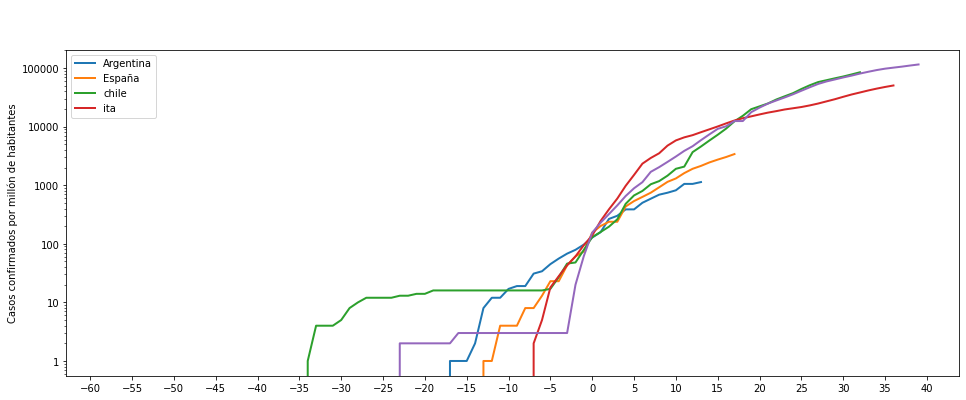

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set(yscale="log")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

for t, y in zip(t_all, y_all):
    sns.lineplot(x=t, y=y, sort=False, linewidth=2)

plt.suptitle("COVID-19 per country cases over the time", fontsize=16, fontweight='bold', color='white')
plt.title("(logarithmic scale)", color='white')

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=0)
plt.ylabel('Casos confirmados por millón de habitantes')

ax.legend(['Argentina', 'España', 'chile', 'ita'])

plt.show()

## another normalization

In [16]:
lst = ['assa''bbbab']
any("ass" in s for s in lst)

True

In [17]:
#list(df_world['country'])

In [18]:
#list(covid_countries_date_df['Country/Region'])

In [19]:
pais = 'South Korea'
pais = 'Korea, South'
any(pais in s for s in df_world['country'])

True

In [20]:
any(pais in s for s in covid_countries_date_df['Country/Region'])

True

In [21]:
%pprint

Pretty printing has been turned OFF


In [22]:
#list(covid_countries_date_df['Country/Region'])

In [23]:
pais = 'US'
df_world[df_world['country'] == pais]

,Unnamed: 0,country,population,area
1,1,US,329064917.0,9525067.0


In [71]:
lista_america = ['Argentina', 'Chile','US','Venezuela','Canada']
lista_europe = ['Germany', 'Iran', 'Italy','United Kingdom','Israel']
lista_asia = ['Japan','Korea, South']
lista_africa = ['South Africa']
lista_oceania = []

lista = lista_america + lista_oceania + lista_europe + lista_asia 
clrs = ['black']*len(lista_america) + ['yellow']*len(lista_oceania) + \
       ['red']*len(lista_europe) + ['blue'] * len(lista_asia)

lstcycle = ['-','--',':','-.','-','-','-','-']
mstyle = lstcycle[0:len(lista_america)] + lstcycle[0:len(lista_oceania)] + \
       lstcycle[0:len(lista_europe)] + lstcycle[0:len(lista_asia)]

y_all = []
t_all = []
critical_number = 100
for pais in lista:
    popu = df_world[df_world['country'] == pais]['population'].values[0]
    area = df_world[df_world['country'] == pais]['area'].values[0]
    covid_pais = covid_countries_date_df[covid_countries_date_df['Country/Region'] == pais]
    
    z = covid_pais['confirmed']
    ind = next(x[0] for x in enumerate(z.values) if x[1] > critical_number)
    patient_100_day = t[ind]
    t_pais = t - patient_100_day   
    y_pais = covid_pais['confirmed'] / popu * 1.e6
    
    y_all.append(y_pais)
    t_all.append(t_pais)

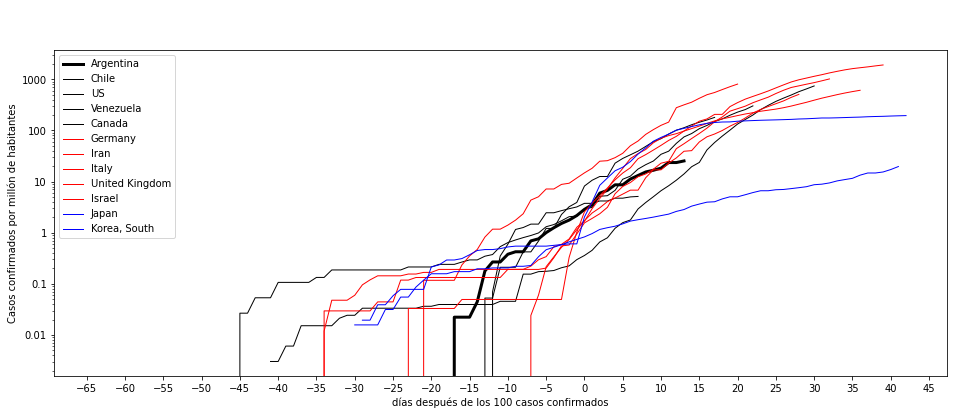

In [74]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set(yscale="log")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

#for t, y in zip(t_all, y_all):
sns.lineplot(x=t_all[0], y=y_all[0], sort=False, linewidth=3, color='black')
for i in range(len(t_all))[1:]:
    sns.lineplot(x=t_all[i], y=y_all[i], sort=False, linewidth=1, color=clrs[i], linestyle=mstyle[i])
    
plt.suptitle("COVID-19 per country cases over the time", fontsize=16, fontweight='bold', color='white')
plt.title("(logarithmic scale)", color='white')

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=0)
plt.xlabel('días después de los 100 casos confirmados')
plt.ylabel('Casos confirmados por millón de habitantes')

ax.legend(lista)

plt.show()